In [ ]:
!pip install accelerate==0.27.2

In [2]:
!mkdir -p contents

In [3]:
import os
import argparse
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torchvision.models import inception_v3
import torch
import torch.nn.functional as F
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [4]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm(expected_shape),
            act()
        )

    def forward(self, x):
        return self.net(x)

# We then create the full CNN model, which is a stack of these blocks
# according to the `n_hidden` tuple, which specifies the number of
# channels at each hidden layer.
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

Next, we define the actual diffusion model, which specifies the trainingschedule, takes an arbitrary model for estimating the diffusion process (such as the CNN above),and computes the corresponding loss (as well as generating samples).

In [5]:
class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_schedules(betas[0], betas[1], n_T)

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Algorithm 18.1 in Prince"""

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting

        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t

define DDGM class for diffusion model using gamma distribution

In [6]:
class DDGM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        theta_0:float,
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddgm_schedules(betas[0], betas[1], theta_0, n_T)

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t
        self.register_buffer("k_t", noise_schedule["k_t"])
        self.k_t
        self.register_buffer("theta_t", noise_schedule["theta_t"])
        self.theta_t
        self.register_buffer("k_t_bar", noise_schedule["k_t_bar"])
        self.k_t_bar

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)

        alpha_t = self.alpha_t[t].reshape(x.shape[0], *([1] * len(x.shape[1:])))
        k_t_bar = self.k_t_bar[t].reshape(x.shape[0], *([1] * len(x.shape[1:]))).repeat(1, *x.shape[1:])
        theta_t = self.theta_t[t].reshape(x.shape[0], *([1] * len(x.shape[1:]))).repeat(1, *x.shape[1:])

        g_t_bar = torch.distributions.Gamma(k_t_bar, 1/theta_t).sample()

        z_t = torch.sqrt(alpha_t) * x + g_t_bar-k_t_bar*theta_t

        return self.criterion((g_t_bar-k_t_bar*theta_t)/torch.sqrt(1-alpha_t), self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        _one = torch.ones(n_sample, device=device)
        theta_T = self.theta_t[self.n_T]
        k_T_bar = self.k_t_bar[self.n_T]
        init_samples_shape= (n_sample, *size)
        z = torch.distributions.Gamma(torch.full(init_samples_shape, k_T_bar), torch.full(init_samples_shape, 1 / theta_T)).sample().to(device=device)
        z_t = z-theta_T*k_T_bar
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            alpha_t_minus_1 = self.alpha_t[i-1]
            beta_t = self.beta_t[i]
            k_t_bar = self.k_t_bar[i]
            theta_t = self.theta_t[i]

            grad = self.gt(z_t, (i/self.n_T) * _one)
            x0 = (1 / alpha_t.sqrt()) * (z_t - (1 - alpha_t).sqrt() * grad)
            z_t = (alpha_t_minus_1.sqrt() * beta_t / (1 - alpha_t)) * x0 + ((1 - beta_t).sqrt() * (1 - alpha_t_minus_1) / (1 - alpha_t)) * z_t

            if i > 1:

                z = torch.distributions.Gamma(torch.full(init_samples_shape, k_t_bar), torch.full(init_samples_shape, 1/theta_t)).sample().to(device=device)
                z = (z-theta_t*k_t_bar)/torch.sqrt(1-alpha_t)
                z_t += torch.sqrt(beta_t) * z

        return z_t

In [7]:
# The following function creates a DDPM training schedule for use when evaluating
# and training the diffusion model:
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}


# The following function creates a DDGM training schedule for use when evaluating
# and training the designed diffusion model:
def ddgm_schedules(beta1: float, beta2: float, theta_0:float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDGM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    k_t = beta_t/(alpha_t*theta_0*theta_0)
    theta_t = torch.sqrt(alpha_t)*theta_0
    k_t_bar = torch.cumsum(k_t, dim=0)
    return {"beta_t": beta_t, "alpha_t":alpha_t, "k_t":k_t, "theta_t":theta_t,"k_t_bar":k_t_bar}

In [8]:
# Define a function to compute the activations
def compute_activations(images, model):
    activations = []
    model.eval()
      # Compute activations
    batch_size = 128
    # device = images.device

    # # Check if CUDA is available
    # if torch.cuda.is_available():
    #     # Define the device
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")
    # device = torch.device("cpu")  # Use CPU device
    device = torch.device("cuda")
    with torch.no_grad():
        for batch in DataLoader(images, batch_size=batch_size):
            batch = batch.to(device)
            pred = model(batch)
            activations.append(pred)
    activations = torch.cat(activations, dim=0)
    return activations

def calculate_fid_score(real_activations, generated_activations):
    # Convert activations to PyTorch tensors
    real_activations_tensor = torch.tensor(real_activations)
    generated_activations_tensor = torch.tensor(generated_activations)

    # Calculate mean and covariance matrices for real and generated activations
    mu_real = torch.mean(real_activations_tensor, dim=0)
    mu_generated = torch.mean(generated_activations_tensor, dim=0)
    sigma_real = torch_cov(real_activations_tensor, rowvar=False)
    sigma_generated = torch_cov(generated_activations_tensor, rowvar=False)

    # Calculate square root of product of covariance matrices
    sqrt_sigma_real_sigma_generated = sqrtm(sigma_real @ sigma_generated)

    # Ensure real-valued result if square root is complex
    if np.iscomplexobj(sqrt_sigma_real_sigma_generated):
        sqrt_sigma_real_sigma_generated = sqrt_sigma_real_sigma_generated.real

    # Calculate FID score
    fid_score = torch.norm(mu_real - mu_generated)**2 + torch.trace(sigma_real + sigma_generated - 2 * sqrt_sigma_real_sigma_generated)
    return fid_score

# Function to calculate covariance matrix
def torch_cov(m, rowvar=False):
    if m.dim() <= 1:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()

def  Calculate_FID_score(real_images, generated_images):
    # Load Inception-v3 model pretrained on ImageNet
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device=x.device)
    inception_model.eval()
  # Preprocess images
    preprocess = transforms.Compose([
      transforms.ToPILImage(),  # Convert tensor to PIL Image
      transforms.Grayscale(num_output_channels=3),  # Convert single channel to three channels
      transforms.Resize(299),
      transforms.CenterCrop(299),
      transforms.ToTensor(),  # Convert image to tensor
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
  ])


    real_images_preprocessed = torch.stack([preprocess(image) for image in real_images])
    generated_images_preprocessed = torch.stack([preprocess(image) for image in generated_images])

  # Compute activations
    batch_size = 128
    device = real_images.device

    real_images_preprocessed = torch.stack([preprocess(image.cpu()) for image in real_images])
    generated_images_preprocessed = torch.stack([preprocess(image.cpu()) for image in generated_images])

  # Compute activations
    real_activations = compute_activations(real_images_preprocessed, inception_model)
    generated_activations = compute_activations(generated_images_preprocessed, inception_model)

  # Move tensors to CPU and detach from computational graph
    real_activations_cpu = real_activations.cpu().detach().numpy()
    generated_activations_cpu = generated_activations.cpu().detach().numpy()

  # Calculate FID score
    fid_score = calculate_fid_score(real_activations_cpu, generated_activations_cpu)
  # print("FID Score:", fid_score.item())
    return fid_score.item()

In [ ]:
# Load dataset
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

In [11]:
# Define the model for estimator
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)

param = "DDGM"
# Choose model either to use Gaussian noise (DDPM) for diffusion or gamma noise (DDGM)
if param == "DDGM":
    model = DDGM(gt=gt, betas=(1e-4, 0.02), theta_0=0.001, n_T=1000)
elif param == "DDPM":
    model = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=2e-4)

# Initialize Accelerator
accelerator = Accelerator()

# Wrap model, optimizer, and dataloader with Accelerate to handle device placement and gradient accumulation
model, optim, dataloader = accelerator.prepare(model, optim, dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
n_epoch = 25
losses = []
avg_losses=[]
fid_scores = []

for i in range(n_epoch):
    model.train()

    pbar = tqdm(dataloader)  # Wrap our loop with a visual progress bar
    for x, _ in pbar:
        optim.zero_grad()

        loss =model(x)

        loss.backward()
        # ^Technically should be `accelerator.backward(loss)` but not necessary for local training

        losses.append(loss.item())
        avg_loss = np.average(losses[min(len(losses)-100, 0):])
        pbar.set_description(f"loss: {avg_loss:.3g}")  # Show running average of loss in progress bar

        optim.step()
    avg_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        xh =model.sample(128, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
        grid = make_grid(xh, nrow=4)

        # Save samples to `./contents` directory
        save_image(grid, f"./contents/sample_{i:04d}.png")

        # save model
        torch.save(model.state_dict(), f"./mnist.pth")
    fid_score = Calculate_FID_score(real_images=x, generated_images=xh)
    fid_scores.append(fid_score)
    # print(fid_scores)
    # print(avg_losses)



  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss: 0.112: 100%|██████████| 468/468 [00:20<00:00, 23.03it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the futur

[1590.251708984375]
[0.11240438592389353]


loss: 0.079: 100%|██████████| 468/468 [00:23<00:00, 20.32it/s]


[1590.251708984375, 1481.772705078125]
[0.11240438592389353, 0.07902193163983269]


loss: 0.065: 100%|██████████| 468/468 [00:18<00:00, 24.70it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153]


loss: 0.0567: 100%|██████████| 468/468 [00:18<00:00, 24.70it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191]


loss: 0.0511: 100%|██████████| 468/468 [00:19<00:00, 23.61it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745]


loss: 0.047: 100%|██████████| 468/468 [00:20<00:00, 22.65it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968]


loss: 0.044: 100%|██████████| 468/468 [00:19<00:00, 23.77it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706]


loss: 0.0416: 100%|██████████| 468/468 [00:19<00:00, 24.05it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716]


loss: 0.0397: 100%|██████████| 468/468 [00:18<00:00, 25.03it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847]


loss: 0.0381: 100%|██████████| 468/468 [00:19<00:00, 24.60it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631]


loss: 0.0367: 100%|██████████| 468/468 [00:19<00:00, 23.70it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405]


loss: 0.0355: 100%|██████████| 468/468 [00:19<00:00, 23.54it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346]


loss: 0.0346: 100%|██████████| 468/468 [00:21<00:00, 22.21it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664]


loss: 0.0337: 100%|██████████| 468/468 [00:19<00:00, 23.90it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578]


loss: 0.0329: 100%|██████████| 468/468 [00:19<00:00, 24.57it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757]


loss: 0.0322: 100%|██████████| 468/468 [00:19<00:00, 24.18it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358]


loss: 0.0315: 100%|██████████| 468/468 [00:22<00:00, 20.82it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325]


loss: 0.031: 100%|██████████| 468/468 [00:19<00:00, 23.49it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674]


loss: 0.0304: 100%|██████████| 468/468 [00:19<00:00, 23.59it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351]


loss: 0.03: 100%|██████████| 468/468 [00:19<00:00, 24.53it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117]


loss: 0.0295: 100%|██████████| 468/468 [00:19<00:00, 24.45it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531, 440.9547119140625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117, 0.02952599111066181]


loss: 0.0291: 100%|██████████| 468/468 [00:19<00:00, 24.26it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531, 440.9547119140625, 452.7335205078125]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117, 0.02952599111066181, 0.029119578218369774]


loss: 0.0287: 100%|██████████| 468/468 [00:19<00:00, 23.63it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531, 440.9547119140625, 452.7335205078125, 411.57891845703125]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117, 0.02952599111066181, 0.029119578218369774, 0.028735371190858696]


loss: 0.0284: 100%|██████████| 468/468 [00:20<00:00, 23.02it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531, 440.9547119140625, 452.7335205078125, 411.57891845703125, 468.42523193359375]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117, 0.02952599111066181, 0.029119578218369774, 0.028735371190858696, 0.028387127611640195]


loss: 0.0281: 100%|██████████| 468/468 [00:20<00:00, 23.28it/s]


[1590.251708984375, 1481.772705078125, 1483.9088134765625, 1392.7384033203125, 1368.3525390625, 1359.810546875, 1326.0250244140625, 1376.8447265625, 1338.1226806640625, 1296.330078125, 1235.8568115234375, 1247.727294921875, 1093.5345458984375, 1031.1490478515625, 802.3070068359375, 629.333984375, 520.0701293945312, 511.45684814453125, 434.476318359375, 421.6736145019531, 440.9547119140625, 452.7335205078125, 411.57891845703125, 468.42523193359375, 428.85009765625]
[0.11240438592389353, 0.07902193163983269, 0.06497075176397153, 0.05668383466008191, 0.051088863043671745, 0.04704243870865968, 0.044005598504464706, 0.0416187072181716, 0.039663346336600847, 0.03807684401364631, 0.03671110450111405, 0.035542675770588346, 0.03455023606718664, 0.03366924472160578, 0.0328890813547757, 0.03217933168020358, 0.031546924521354325, 0.030963114551458674, 0.03043724941766351, 0.029968102780294117, 0.02952599111066181, 0.029119578218369774, 0.028735371190858696, 0.028387127611640195, 0.0280684074443470

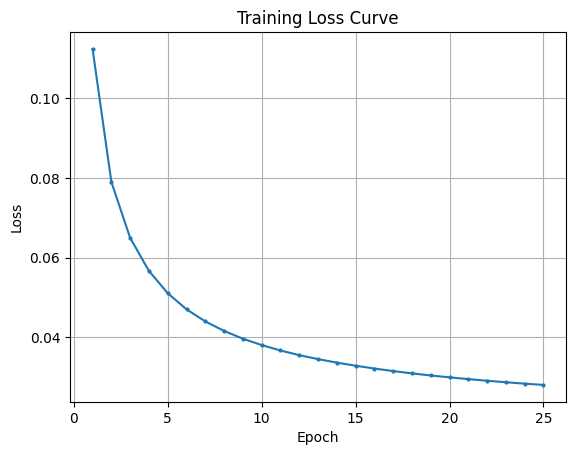

In [16]:
    # Plot the loss curve
    plt.plot(range(1, n_epoch + 1), avg_losses, marker='o', linestyle='-', markersize=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()


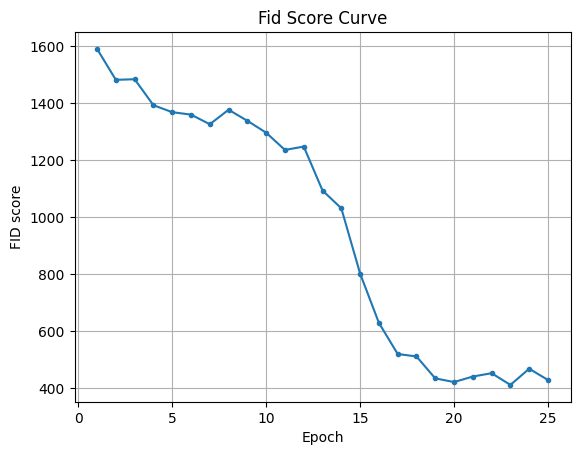

In [17]:
    # Plot the fid curve
    plt.plot(range(1, n_epoch + 1), fid_scores, marker='o', linestyle='-', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('FID score')
    plt.title('Fid Score Curve')
    plt.grid(True)
    plt.show()